# Introduction

## Libraries

In [11]:
%pip install ipywidgets rich

  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)
Note: you may need to restart the kernel to use updated packages.


## Ingestion

In [23]:
from pathlib import Path
from typing import List, Dict, Optional, Union, Tuple
from dataclasses import dataclass
import pydicom
import numpy as np
import torch
from tqdm import tqdm
from rich.console import Console
import logging
from datetime import datetime

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

@dataclass
class DICOMMetadata:
    """Data class to store relevant DICOM metadata."""
    patient_id: str
    study_date: str
    modality: str
    manufacturer: str
    pixel_spacing: Tuple[float, float]
    image_shape: Tuple[int, ...]

class DATSCANIngestion:
    """Class for handling DATSCAN DICOM data ingestion.
    
    This class provides functionality to:
    1. Recursively find DICOM files in a directory structure
    2. Load and validate DICOM files
    3. Convert DICOM data to numpy arrays
    4. Optionally transfer data to GPU using PyTorch
    
    Attributes:
        root_dir (Path): Root directory containing DICOM files
        device (torch.device): Device to use for PyTorch operations
        console (Console): Rich console for enhanced output
    """
    
    def __init__(
        self,
        root_dir: Union[str, Path],
        use_gpu: bool = True,
        file_pattern: str = "*.dcm"
    ):
        """Initialize the DATSCAN ingestion handler.
        
        Args:
            root_dir: Path to the root directory containing DICOM files
            use_gpu: Whether to use GPU for processing (if available)
            file_pattern: Pattern to match DICOM files
        """
        self.root_dir = Path(root_dir)
        self.file_pattern = file_pattern
        self.console = Console()
        
        # Set up device for PyTorch operations
        self.device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
        logger.info(f"Using device: {self.device}")
        
        # Validate root directory
        if not self.root_dir.exists():
            raise ValueError(f"Root directory does not exist: {self.root_dir}")
        
        logger.info(f"Initialized DATSCANIngestion with root directory: {self.root_dir}")

    def find_dicom_files(self) -> List[Path]:
        """Recursively find all DICOM files in the root directory.
        
        Returns:
            List of Path objects for all DICOM files found
        """
        try:
            dicom_files = list(self.root_dir.rglob(self.file_pattern))
            logger.info(f"Found {len(dicom_files)} DICOM files")
            return dicom_files
        except Exception as e:
            logger.error(f"Error finding DICOM files: {e}")
            raise

    def validate_dicom(self, ds: pydicom.dataset.FileDataset) -> bool:
        """Validate DICOM metadata for DATSCAN compatibility.
        
        Args:
            ds: PyDICOM dataset to validate
            
        Returns:
            bool: Whether the DICOM file is valid for our purposes
        """
        required_attributes = [
            'PatientID',
            'StudyDate',
            'Modality',
            'Manufacturer',
            'PixelSpacing'
        ]
        
        return all(hasattr(ds, attr) for attr in required_attributes)

    def extract_metadata(self, ds: pydicom.dataset.FileDataset) -> DICOMMetadata:
        """Extract relevant metadata from DICOM dataset.
        
        Args:
            ds: PyDICOM dataset
            
        Returns:
            DICOMMetadata object containing relevant metadata
        """
        return DICOMMetadata(
            patient_id=ds.PatientID,
            study_date=ds.StudyDate,
            modality=ds.Modality,
            manufacturer=ds.Manufacturer,
            pixel_spacing=tuple(ds.PixelSpacing),
            image_shape=ds.pixel_array.shape
        )

    def load_dicom(self, file_path: Path) -> Tuple[np.ndarray, DICOMMetadata]:
        """Load a single DICOM file and return its pixel array and metadata.
        
        Args:
            file_path: Path to the DICOM file
            
        Returns:
            Tuple containing:
            - np.ndarray: The pixel array data
            - DICOMMetadata: Metadata extracted from the DICOM file
        """
        try:
            ds = pydicom.dcmread(file_path)
            
            if not self.validate_dicom(ds):
                raise ValueError(f"Invalid DICOM file: {file_path}")
            
            # Extract pixel array and convert to float32
            pixel_array = ds.pixel_array.astype(np.float32)
            
            # Extract metadata
            metadata = self.extract_metadata(ds)
            
            logger.debug(f"Successfully loaded DICOM file: {file_path}")
            return pixel_array, metadata
            
        except Exception as e:
            logger.error(f"Error loading DICOM file {file_path}: {e}")
            raise

    def load_batch(
        self,
        max_files: Optional[int] = None,
        return_torch: bool = True
    ) -> Tuple[Union[np.ndarray, torch.Tensor], List[DICOMMetadata]]:
        """Load multiple DICOM files and return as a batch.
        
        Args:
            max_files: Maximum number of files to load (None for all files)
            return_torch: If True, return torch.Tensor instead of np.ndarray
            
        Returns:
            Tuple containing:
            - Union[np.ndarray, torch.Tensor]: Batch of images
            - List[DICOMMetadata]: List of metadata for each image
        """
        # Find all DICOM files
        dicom_files = self.find_dicom_files()
        
        if max_files is not None:
            dicom_files = dicom_files[:max_files]
        
        # Lists to store results
        images = []
        metadata_list = []
        
        # Load files with progress bar
        self.console.print(f"Loading {len(dicom_files)} DICOM files...")
        for file_path in tqdm(dicom_files, desc="Loading DICOM files"):
            try:
                image, metadata = self.load_dicom(file_path)
                images.append(image)
                metadata_list.append(metadata)
            except Exception as e:
                logger.warning(f"Skipping file {file_path} due to error: {e}")
                continue
        
        # Stack images into a single array
        image_batch = np.stack(images)
        
        # Convert to torch tensor if requested
        if return_torch:
            image_batch = torch.from_numpy(image_batch).to(self.device)
            logger.info(f"Converted data to torch tensor on {self.device}")
        
        logger.info(f"Successfully loaded {len(images)} DICOM files")
        return image_batch, metadata_list

print("DATSCAN Ingestion module loaded successfully!")

DATSCAN Ingestion module loaded successfully!


# DICOM Preprocessing

In [30]:
# Example usage of the DATSCANIngestion class
def main():
    # Initialize the ingestion handler
    data_loader = DATSCANIngestion(
        root_dir="Images/PPMI_Images",  # Update this path as needed
        use_gpu=True
    )
    
    try:
        # Load a batch of images (first 5 for testing)
        images, metadata = data_loader.load_batch(max_files=10)
        
        # Print summary of loaded data
        print(f"\nLoaded data summary:")
        print(f"Number of images: {len(metadata)}")
        if isinstance(images, torch.Tensor):
            print(f"Image batch shape: {images.shape}")
            print(f"Data type: {images.dtype}")
            print(f"Device: {images.device}")
        else:
            print(f"Image batch shape: {images.shape}")
            print(f"Data type: {images.dtype}")
        
        # Print first image metadata as example
        if metadata:
            print("\nExample metadata from first image:")
            print(f"Patient ID: {metadata[0].patient_id}")
            print(f"Study Date: {metadata[0].study_date}")
            print(f"Image Shape: {metadata[0].image_shape}")
            print(f"Pixel Spacing: {metadata[0].pixel_spacing}")
    
    except Exception as e:
        print(f"Error during data loading: {e}")

if __name__ == "__main__":
    main()

2024-11-16 16:10:30,442 - INFO - Using device: cuda
2024-11-16 16:10:30,442 - INFO - Initialized DATSCANIngestion with root directory: Images\PPMI_Images
2024-11-16 16:10:31,226 - INFO - Found 3875 DICOM files


Loading 10 DICOM files...

Loading DICOM files:   0%|          | 0/10 [00:00<?, ?it/s]2024-11-16 16:10:31,232 - ERROR - Error loading DICOM file Images\PPMI_Images\100001\Reconstructed_DaTSCAN\2020-09-09_17_07_33.0\I1452480\PPMI_100001_NM_Reconstructed_DaTSCAN_Br_20210608102518754_1_S1028880_I1452480.dcm: Invalid DICOM file: Images\PPMI_Images\100001\Reconstructed_DaTSCAN\2020-09-09_17_07_33.0\I1452480\PPMI_100001_NM_Reconstructed_DaTSCAN_Br_20210608102518754_1_S1028880_I1452480.dcm
2024-11-16 16:10:31,232 - WARNING - Skipping file Images\PPMI_Images\100001\Reconstructed_DaTSCAN\2020-09-09_17_07_33.0\I1452480\PPMI_100001_NM_Reconstructed_DaTSCAN_Br_20210608102518754_1_S1028880_I1452480.dcm due to error: Invalid DICOM file: Images\PPMI_Images\100001\Reconstructed_DaTSCAN\2020-09-09_17_07_33.0\I1452480\PPMI_100001_NM_Reconstructed_DaTSCAN_Br_20210608102518754_1_S1028880_I1452480.dcm
2024-11-16 16:10:31,283 - ERROR - Error loading DICOM file Images\PPMI_Images\100001\Reconstructed_DaTSCAN\2024-09-11_15_13_41.0\I109


Loaded data summary:
Number of images: 8
Image batch shape: torch.Size([8, 91, 109, 91])
Data type: torch.float32
Device: cuda:0

Example metadata from first image:
Patient ID: 100001
Study Date: 20210406
Image Shape: (91, 109, 91)
Pixel Spacing: ('2.0', '2.0')


2024-11-16 16:11:34,336 - INFO - Using device: cuda
2024-11-16 16:11:34,337 - INFO - Initialized DATSCANIngestion with root directory: Images_Test\dicom
2024-11-16 16:11:34,339 - INFO - Found 6 DICOM files


Loading 5 DICOM files...

Loading DICOM files: 100%|██████████| 5/5 [00:00<00:00, 274.99it/s]
2024-11-16 16:11:34,371 - INFO - Converted data to torch tensor on cuda
2024-11-16 16:11:34,371 - INFO - Successfully loaded 5 DICOM files


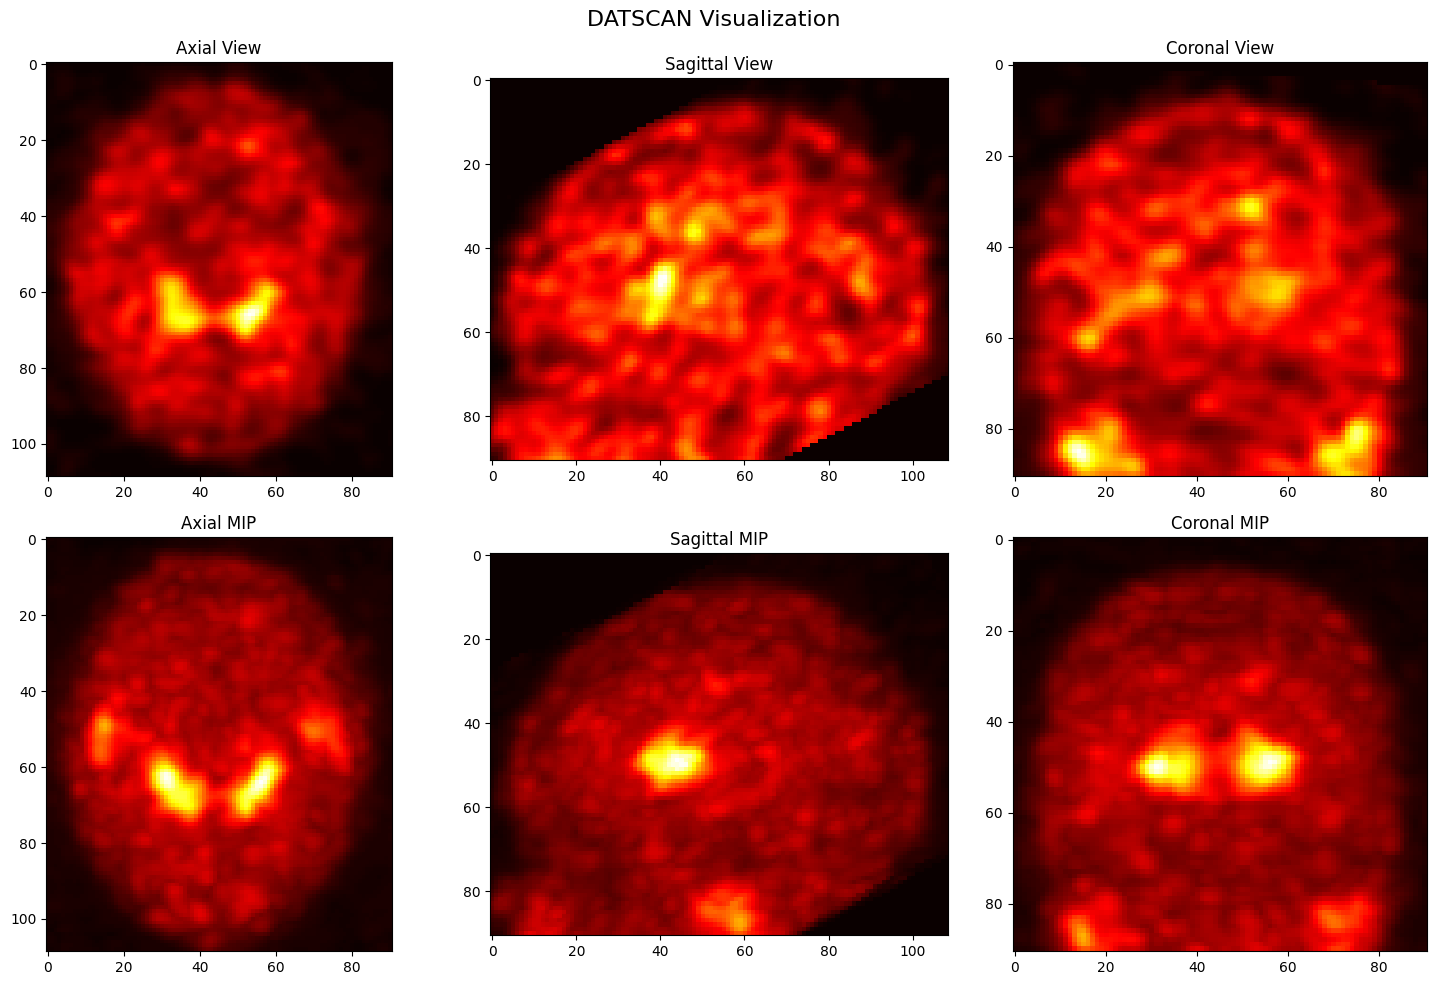

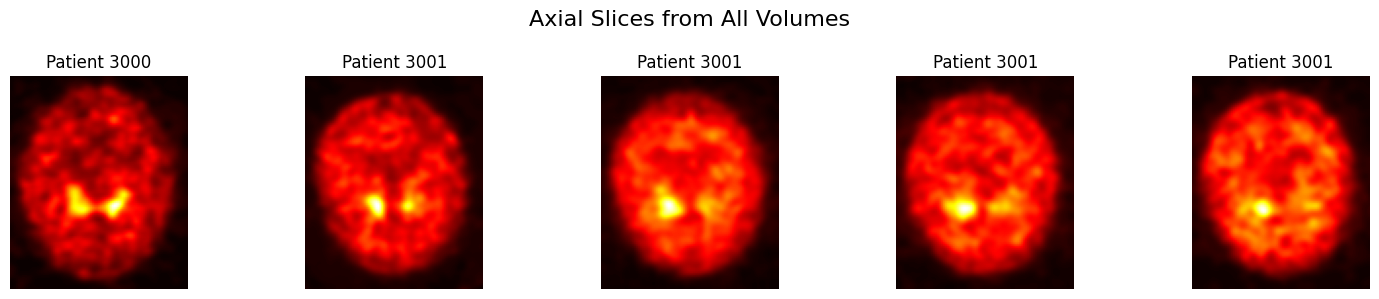

In [33]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

def visualize_3d_scan(data_loader: DATSCANIngestion, max_files: int = 10):
    """
    Visualize 3D DATSCAN volumes with multiple views.
    Views are properly flipped vertically to match standard radiological convention.
    """
    # Load the data
    volumes, metadata = data_loader.load_batch(max_files=max_files, return_torch=True)
    volumes = volumes.cpu().numpy()  # Convert back to numpy for matplotlib
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(15, 10))
    plt.suptitle("DATSCAN Visualization", fontsize=16)
    
    # 1. Show orthogonal views of first volume
    ax1 = plt.subplot(231)
    ax2 = plt.subplot(232)
    ax3 = plt.subplot(233)
    
    volume = volumes[0]
    
    # Get middle slices for each view with proper orientation
    # Coronal view
    axial_slice = np.flipud(volume[:, :, volume.shape[2]//2])
    # Sagittal view
    coronal_slice = np.flipud(volume[:, volume.shape[1]//2, :])
    # Axial view
    sagittal_slice = np.flipud(volume[volume.shape[0]//2, :, :])
    
    ax1.imshow(sagittal_slice, cmap='hot')
    ax1.set_title('Axial View')
    ax2.imshow(axial_slice, cmap='hot')
    ax2.set_title('Sagittal View')
    ax3.imshow(coronal_slice, cmap='hot')
    ax3.set_title('Coronal View')
    
    # 2. Show Maximum Intensity Projections
    ax4 = plt.subplot(234)
    ax5 = plt.subplot(235)
    ax6 = plt.subplot(236)
    
    # Calculate MIPs
    sagittal_mip = np.flipud(np.max(volume, axis=0))
    axial_mip = np.flipud(np.max(volume, axis=2))
    coronal_mip = np.flipud(np.max(volume, axis=1))
    
    ax4.imshow(sagittal_mip, cmap='hot')
    ax4.set_title('Axial MIP')
    ax5.imshow(axial_mip, cmap='hot')
    ax5.set_title('Sagittal MIP')
    ax6.imshow(coronal_mip, cmap='hot')
    ax6.set_title('Coronal MIP')
    
    plt.tight_layout()
    plt.show()
    
    # Create a second figure showing axial slices from all volumes
    fig2, axes = plt.subplots(1, min(5, len(volumes)), figsize=(15, 3))
    plt.suptitle("Axial Slices from All Volumes", fontsize=16)
    
    for i, volume in enumerate(volumes):
        axial_slice = np.flipud(volume[volume.shape[0]//2, :, :])
        axes[i].imshow(axial_slice, cmap='hot')
        axes[i].set_title(f'Patient {metadata[i].patient_id}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    data_loader = DATSCANIngestion(
        root_dir="Images_Test/dicom",  # Update path as needed
        use_gpu=True
    )
    visualize_3d_scan(data_loader, max_files=5)